In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# 展示高清图
from matplotlib_inline import backend_inline
backend_inline.set_matplotlib_formats('svg')

In [3]:
# 准备数据集
df = pd.read_csv('Data.csv', index_col=0)    # 导入数据
arr = df.values                 # Pandas对象退化为NumPy数组
arr = arr.astype(np.float32)    # 转为float32类型数组
ts = torch.tensor(arr)          # 数组转为张量
ts = ts.to('cuda')              # 把训练集搬到cuda上
ts.shape

torch.Size([759, 9])

In [4]:
# 划分训练集与测试集
train_size = int(len(ts) * 0.7)          # 训练集的样本数量
test_size  = len(ts) - train_size        # 测试集的样本数量
ts = ts[torch.randperm(ts.size(0)),:]    # 打乱样本的顺序
train_Data = ts[:train_size,:]           # 训练集样本
test_Data  = ts[train_size:,:]           # 测试集样本
train_Data.shape, test_Data.shape

(torch.Size([531, 9]), torch.Size([228, 9]))

In [5]:
class DNN(nn.Module):
    
    def __init__(self):
        ''' 搭建神经网络各层 '''
        super(DNN, self).__init__()
        self.net = nn.Sequential(              # 按顺序搭建各层
            nn.Linear(8, 32), nn.Sigmoid(),    # 第1层：全连接层
            nn.Linear(32, 8), nn.Sigmoid(),    # 第2层：全连接层
            nn.Linear(8, 4), nn.Sigmoid(),     # 第3层：全连接层
            nn.Linear(4, 1), nn.Sigmoid()      # 第4层：全连接层
        )

    def forward(self, x):
        ''' 前向传播 '''
        y = self.net(x)    # x即输入数据
        return y           # y即输出数据

In [6]:
model = DNN().to('cuda')    # 创建子类的实例，并搬到GPU上
model                       # 查看该实例的各层

DNN(
  (net): Sequential(
    (0): Linear(in_features=8, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=8, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Sigmoid()
    (6): Linear(in_features=4, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [7]:
# 损失函数的选择
loss_fn = nn.BCELoss(reduction='mean')

In [8]:
# 优化算法的选择
learning_rate = 0.005    # 设置学习率
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

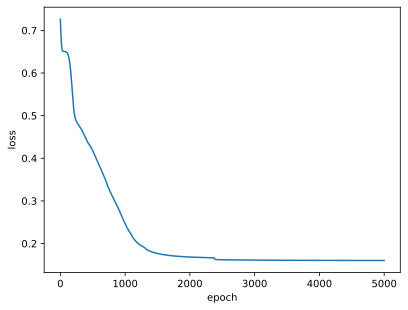

In [9]:
# 训练网络
epochs = 5000
losses = []       # 记录损失函数变化的列表

# 给训练集划分输入与输出
X = train_Data[:, :-1]                   # 前8列为输入特征
Y = train_Data[:, -1].reshape((-1,1))    # 后1列为输出特征，.reshape((-1,1))将一阶张量升级为二阶

for epoch in range(epochs):
    Pred = model(X)               # 一次前向传播（批量）
    loss = loss_fn(Pred, Y)       # 计算损失函数
    losses.append(loss.item())    # 记录损失函数的变化
    optimizer.zero_grad()         # 清空梯度
    loss.backward()               # 一次反向传播
    optimizer.step()              # 优化内部参数

Fig = plt.figure()
plt.plot(range(epochs), losses)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [10]:
# 测试网络

# 给测试集划分输入与输出
X = test_Data[ : , : -1 ]                  # 前8列为输入特征
Y = test_Data[ : , -1 ].reshape((-1,1))    # 后1列为输出特征

with torch.no_grad():    # 该局部关闭梯度计算功能
    Pred = model(X)      # 一次前向传播（批量）
    Pred[Pred>=0.5] = 1
    Pred[Pred<0.5] = 0
    correct = torch.sum( (Pred == Y).all(1) )    # 预测正确的样本
    total = Y.size(0)                            # 全部的样本数量
    print(f'测试集精准度: {100*correct/total} %')

测试集精准度: 70.6140365600586 %
